## This note book is for combining the inpainted blocks for each single box (combining blocks), and creating the model

The wcs of the map, the good/bad block list, and the input/output path should be set manually before running the notebook

In [1]:
import os
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import matplotlib
from datetime import datetime
import time
import pickle
import museek.util.tools as tl
import astropy.coordinates as ac
from astropy import units as u
import astropy
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
import pysm3
import healpy as hp
import gc
import random
import warnings
from museek.enums.result_enum import ResultEnum
from scipy import interpolate
from museek.rfi_mitigation.aoflagger_1d import gaussian_filter_1d
from scipy.ndimage import median_filter
import scipy

plt.style.use('classic')
plt.subplots_adjust(bottom=0.15,top=0.95,left=0.15,right=0.95)

from matplotlib import rcParams
params={'font.family':'DejaVu Serif',
        'font.serif':'Times New Roman',
        'font.style':'normal',
        'font.weight':'normal',
        }
rcParams.update(params)

plt.rcParams['xtick.major.pad']='3'
plt.rcParams['ytick.major.pad']='2'
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.rcParams['figure.facecolor']='white'
plt.rcParams['axes.facecolor']='white'


def project_2d(x, y, data, shape, weights=None):
    """Project x,y, data TOIs on a 2D grid.

    Parameters
    ----------
    x, y : array_like
        input pixel indexes, 0 indexed convention
    data : array_like
        input data to project
    shape : int or tuple of int
        the shape of the output projected map
    weights : array_like
        weights to be use to sum the data (by default, ones)

    Returns
    -------
    data, weight, hits : ndarray
        the projected data set and corresponding weights and hits

    Notes
    -----
    The pixel index must follow the 0 indexed convention, i.e. use `origin=0` in `*_worl2pix` methods from `~astropy.wcs.WCS`.

    >>> data, weight, hits = project([0], [0], [1], 2)
    >>> data
    array([[ 1., nan],
    
           [nan, nan]])
    >>> weight
    array([[1., 0.],
           [0., 0.]])
    >>> hits
    array([[1, 0],
           [0, 0]]))

    >>> data, _, _ = project([-0.4], [0], [1], 2)
    >>> data
    array([[ 1., nan],
           [nan, nan]])

    There is no test for out of shape data

    >>> data, _, _ = project([-0.6, 1.6], [0, 0], [1, 1], 2)
    >>> data
    array([[nan, nan],
           [nan, nan]])

    Weighted means are also possible :
    
    >>> data, weight, hits = project([-0.4, 0.4], [0, 0], [0.5, 2], 2, weights=[2, 1])
    >>> data
    array([[ 1., nan],
           [nan, nan]))
    >>> weight
    array([[3., 0.],
           [0., 0.]])
    >>> hits
    array([[2, 0],
           [0, 0]])
    """
    if isinstance(shape, (int, np.integer)):
        shape = (shape, shape)

    assert len(shape) == 2, "shape must be a int or have a length of 2"

    if not isinstance(data, np.ndarray):
        data = np.asarray(data)

    if weights is None:
        weights = np.ones(data.shape)

    if isinstance(data, np.ma.MaskedArray):
        # Put weights as 0 for masked data
        hit_weights = ~data.mask
        weights = weights * hit_weights
    else:
        hit_weights = np.ones_like(data, dtype=bool)

    kwargs = {"bins": shape, "range": tuple((-0.5, size - 0.5) for size in shape)}

    _hits, xedges, yedges = np.histogram2d(y, x, weights=hit_weights, **kwargs)
    _weights = np.histogram2d(y, x, weights=weights, **kwargs)[0]
    _data = np.histogram2d(y, x, weights=weights * data, **kwargs)[0]

    #with warnings.catch_warnings():
    #    warnings.simplefilter("ignore")
    #    output = _data / _weights

    return _data, _weights, _hits.astype(int), xedges, yedges

def polynomial_flag_outlier(x, y, mask, degree, threshold):
    """
    fitting a powerlaw to the input data and mask outliers which deviate the powerlaw larger than `threshold' times median absolute deviation

    Parameters:
    x: x-coordinates of the sample points [array]
    y: y-coordinates of the sample points [array]
    mask: mask for the sample points [bool]
    degree: Degree of the fitting polynomial [int]
    threshold: threshold of the masking [float]

    Returns:
    bool array: updated mask
    1darray: fitting polynomial coefficients
    """

    initial_mask = mask.copy()
    #struct = np.ones(self.struct_size[1], dtype=bool)
    ########  mask the whole data if the flagged fraction is larger than 0.5
    if np.mean(mask>0) > 0.5:
        initial_mask[:] = True
        p_fit = None
    else:
       fit_x = x[~mask]
       fit_y = y[~mask]

       # Fit a polynomial
       p_fit = np.polyfit(fit_x, fit_y, degree)
       y_fit = np.polyval(p_fit, fit_x)

       # Calculate residuals
       residuals = fit_y - y_fit
       mad_residuals = scipy.stats.median_abs_deviation(residuals)

       # Identify outliers
       initial_mask[~mask] |= np.abs(residuals) >= threshold * mad_residuals

       #to_dilate = initial_mask ^ mask
       #dilated = ndimage.binary_dilation(to_dilate, structure=struct, iterations=1)
       #initial_mask = initial_mask + dilated

    return initial_mask, p_fit

<Figure size 640x480 with 0 Axes>

In [2]:
####  parameters initialization
block_name_list = ['1710186924', '1710878483', '1712085987', '1713047732', '1721666164', '1710272607', 
                   '1710964969', '1712172417', '1713133906', '1721751682', '1710358887', '1711223036',  
                   '1713222040', '1722185106', '1710533408', '1711395125', '1713306983', '1723046486', 
                   '1710618377', '1712015185', '1712685146', '1714428474', '1710703585', '1712791459', 
                   '1716498372'] ## BOX3

bad_block_list = ['1711395125', '1712015185', '1711223036', '1713306983', '1713222040']  ## bad blocks 
block_process_list = [block_name for block_name in block_name_list if block_name not in bad_block_list]  ## excluding bad blocks

BOX = 'BOX3'
input_path = '/idia/users/wkhu/calibration_results/'+BOX+'/maps/'
output_path = '/idia/users/wkhu/calibration_results/'+BOX+'/maps/'

model_polyfit_deg = 6  ### polynomial degree for model fitting

map_version = '_inpainting'  ### the version (selfcali or not) of the map   
#map_version = '_selfcali_inpainting' 


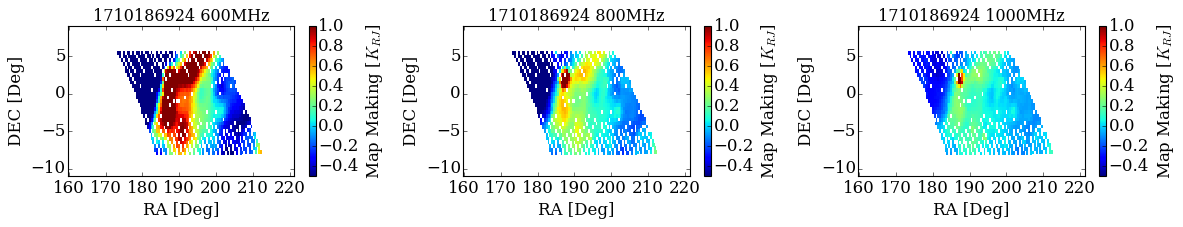

<Figure size 640x480 with 0 Axes>

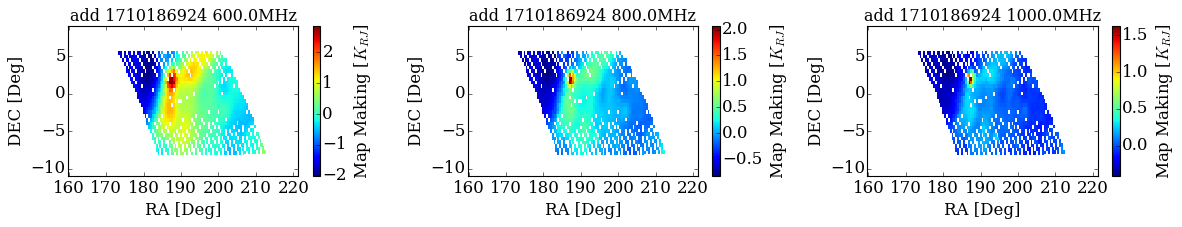

<Figure size 640x480 with 0 Axes>

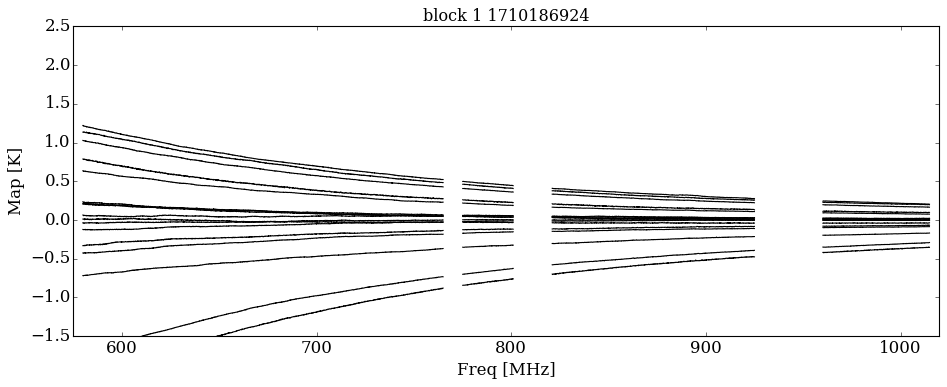

<Figure size 640x480 with 0 Axes>

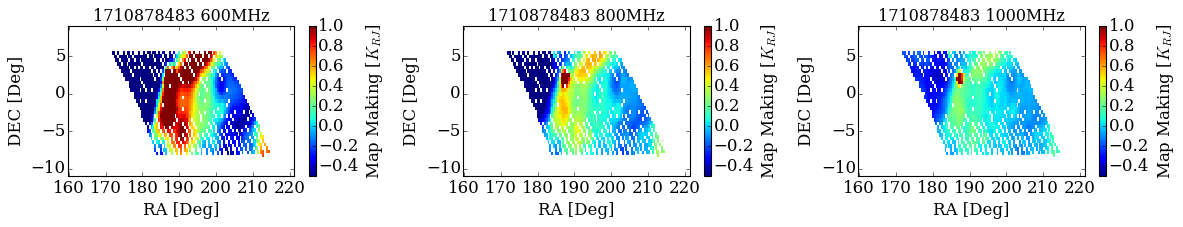

<Figure size 640x480 with 0 Axes>

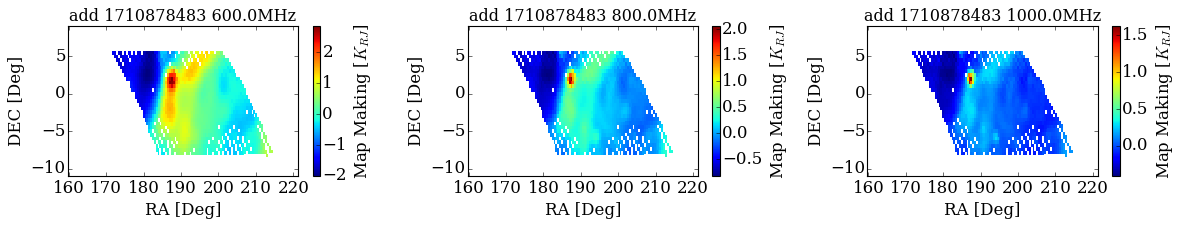

<Figure size 640x480 with 0 Axes>

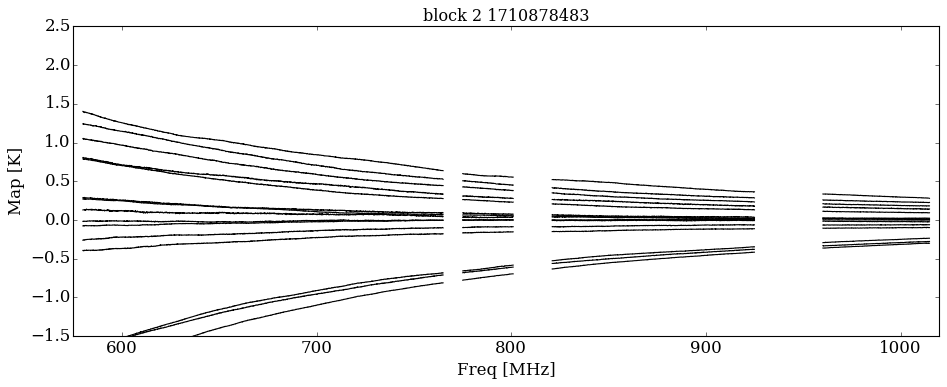

<Figure size 640x480 with 0 Axes>

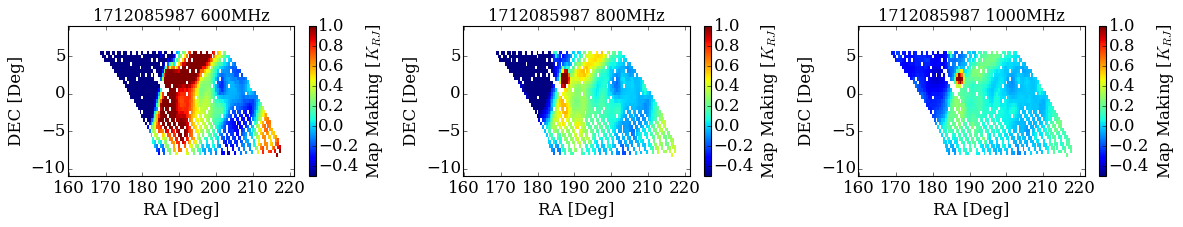

<Figure size 640x480 with 0 Axes>

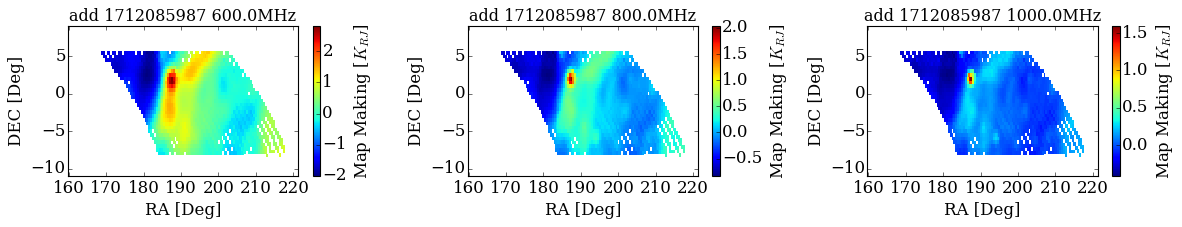

<Figure size 640x480 with 0 Axes>

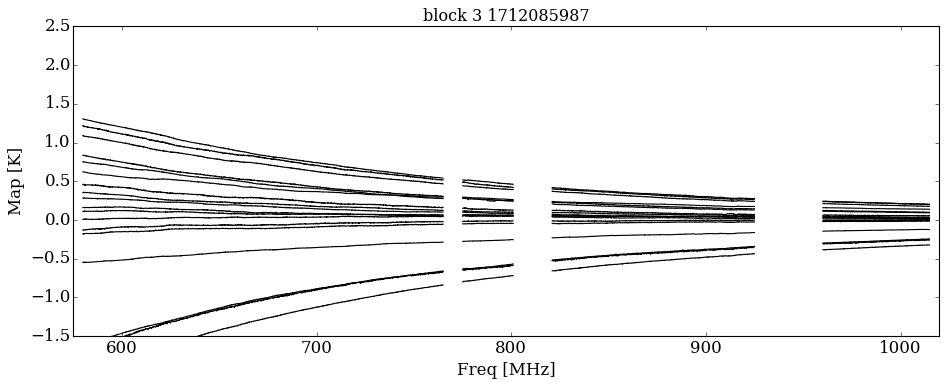

<Figure size 640x480 with 0 Axes>

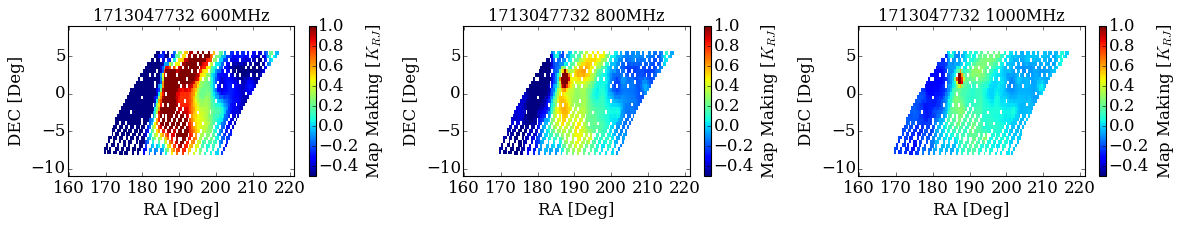

<Figure size 640x480 with 0 Axes>

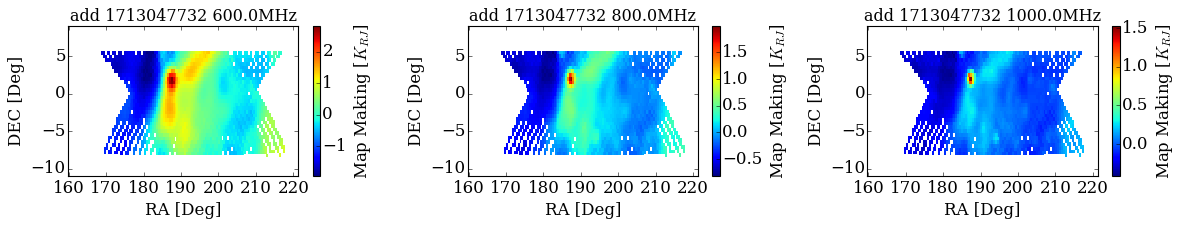

<Figure size 640x480 with 0 Axes>

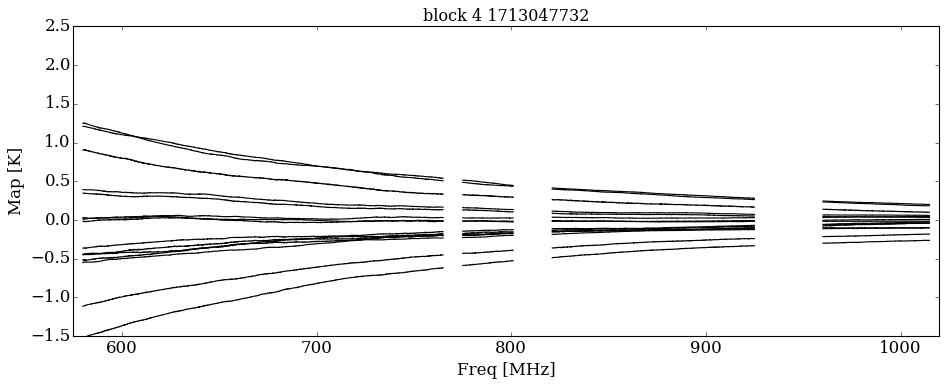

<Figure size 640x480 with 0 Axes>

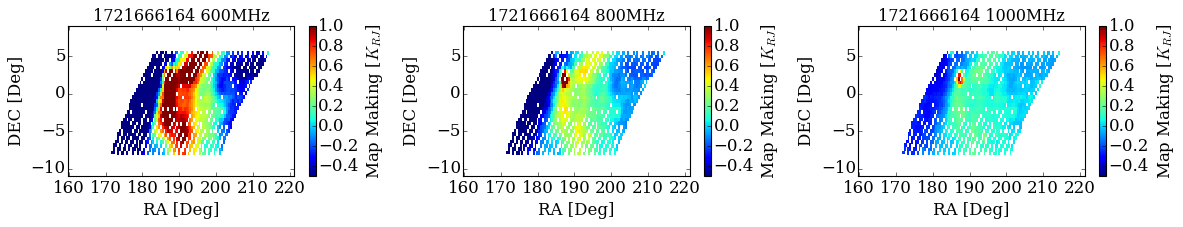

<Figure size 640x480 with 0 Axes>

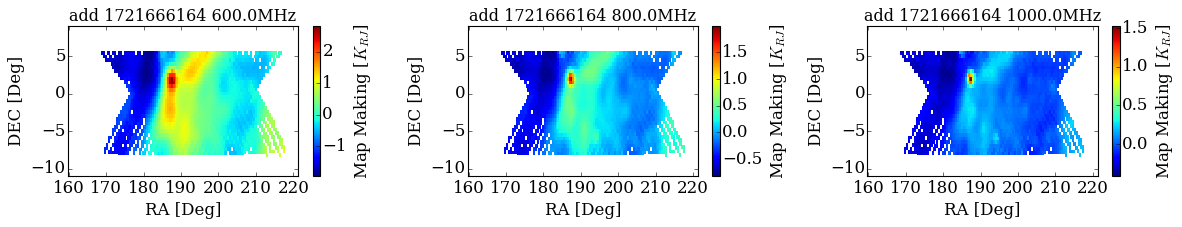

<Figure size 640x480 with 0 Axes>

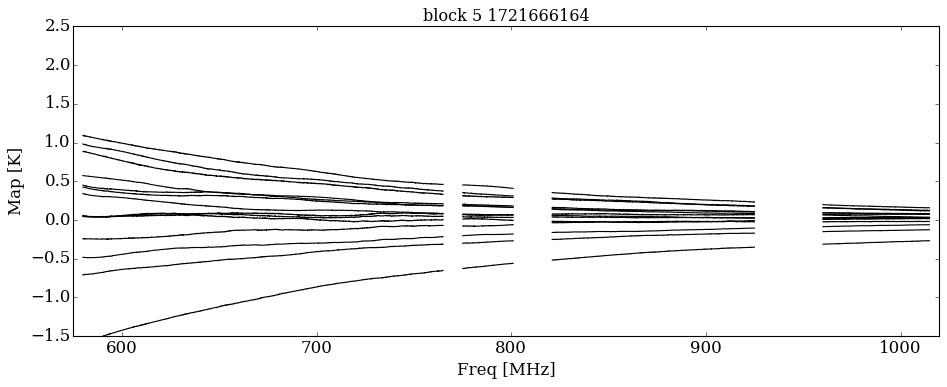

<Figure size 640x480 with 0 Axes>

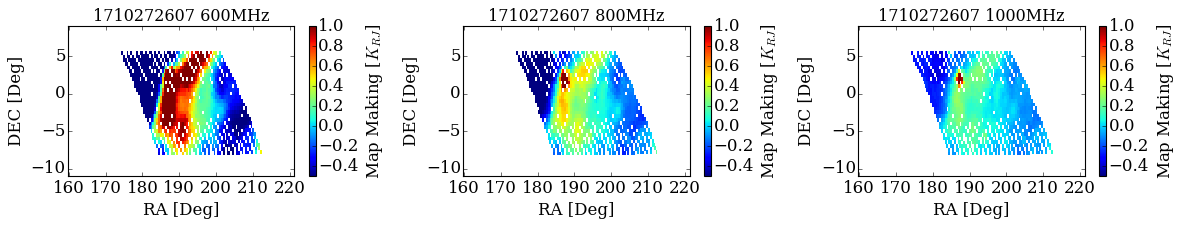

<Figure size 640x480 with 0 Axes>

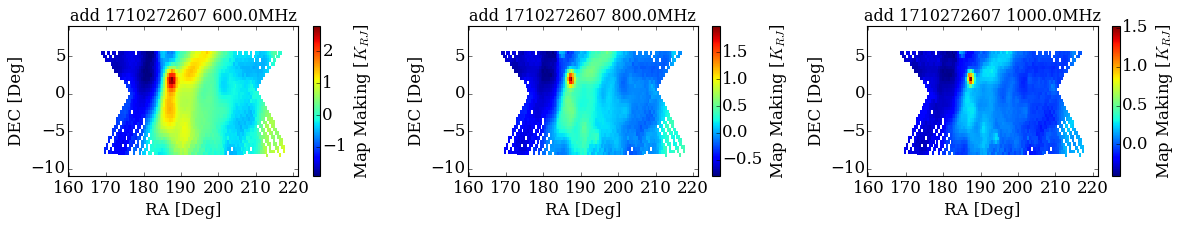

<Figure size 640x480 with 0 Axes>

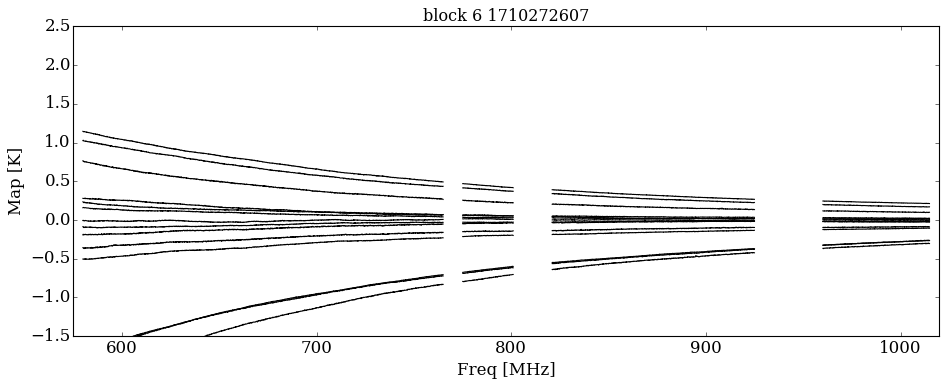

<Figure size 640x480 with 0 Axes>

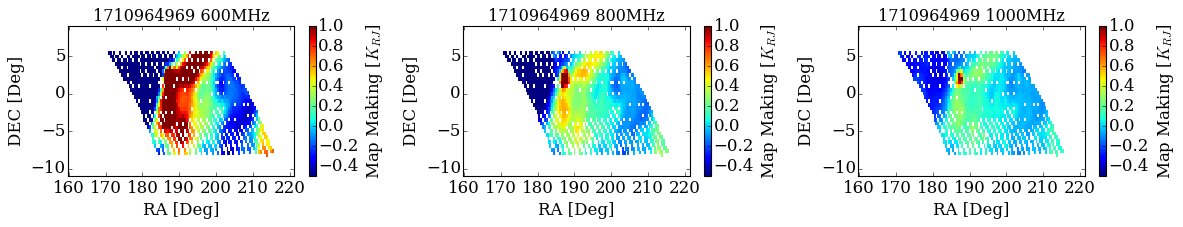

<Figure size 640x480 with 0 Axes>

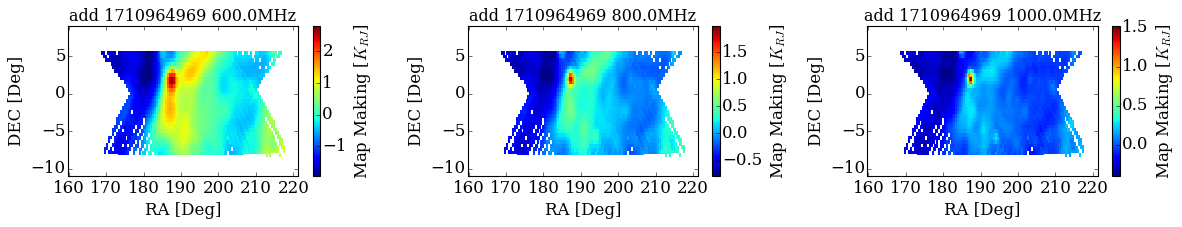

<Figure size 640x480 with 0 Axes>

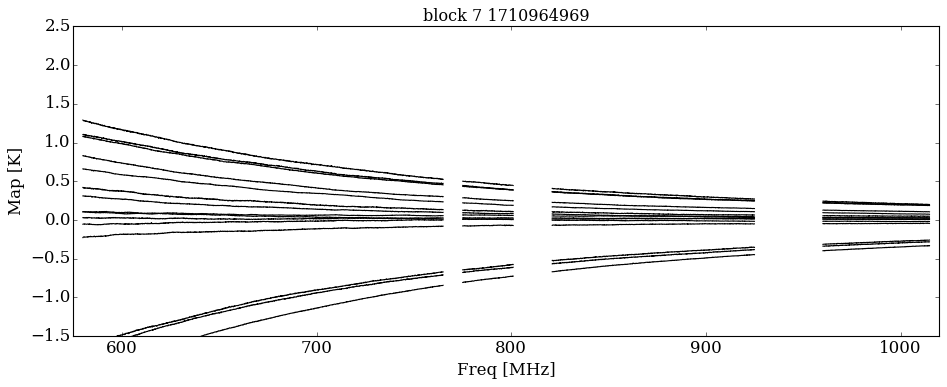

<Figure size 640x480 with 0 Axes>

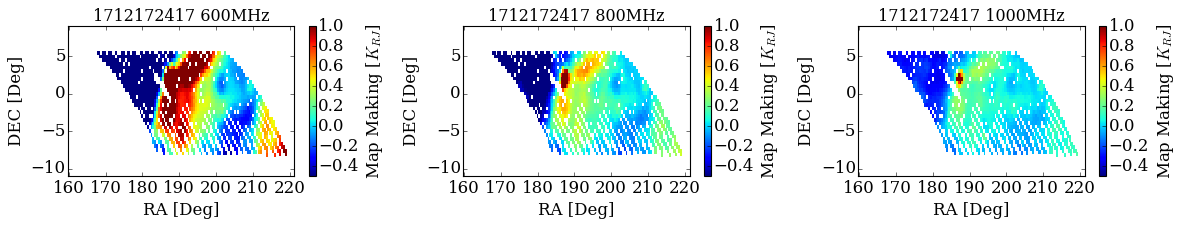

<Figure size 640x480 with 0 Axes>

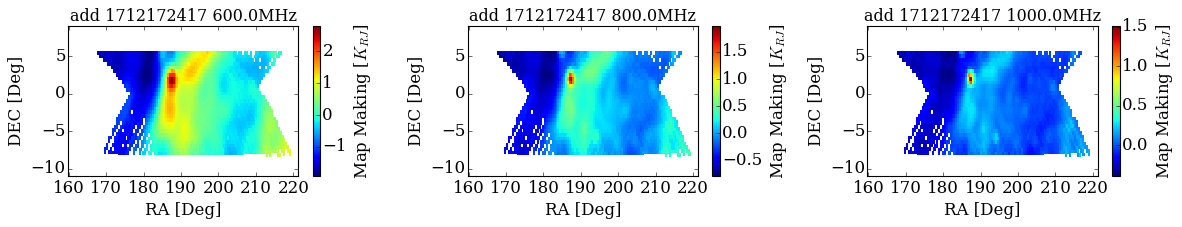

<Figure size 640x480 with 0 Axes>

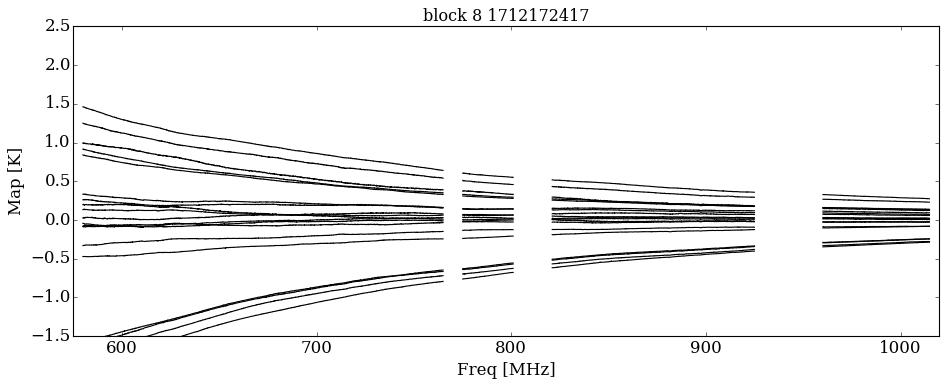

<Figure size 640x480 with 0 Axes>

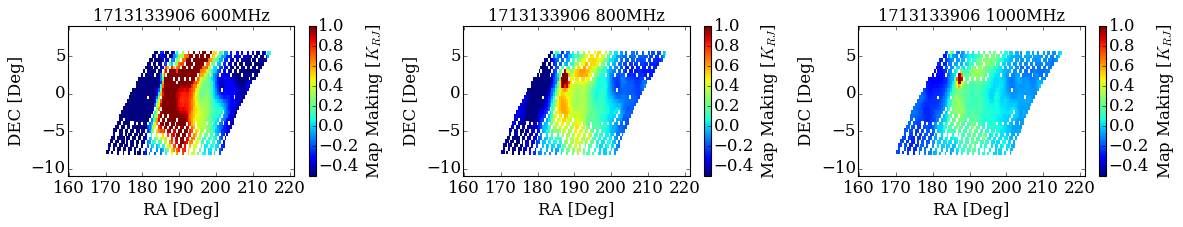

<Figure size 640x480 with 0 Axes>

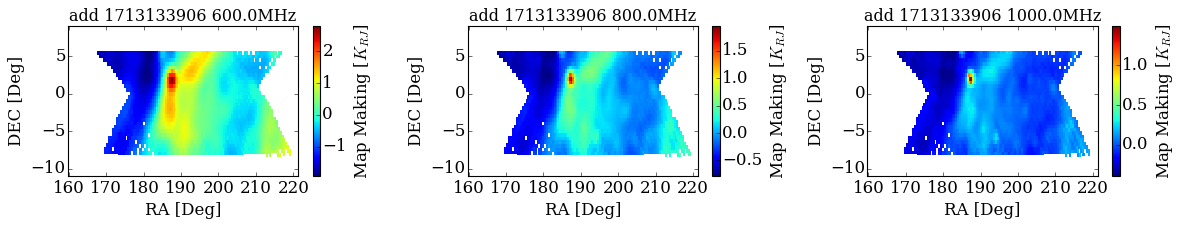

<Figure size 640x480 with 0 Axes>

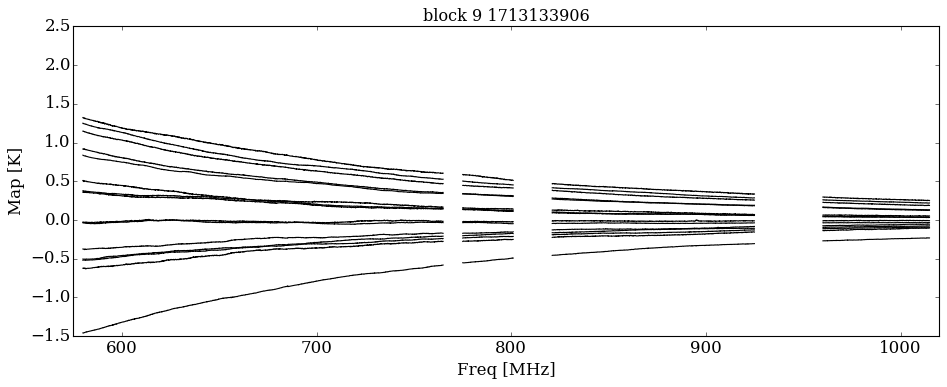

<Figure size 640x480 with 0 Axes>

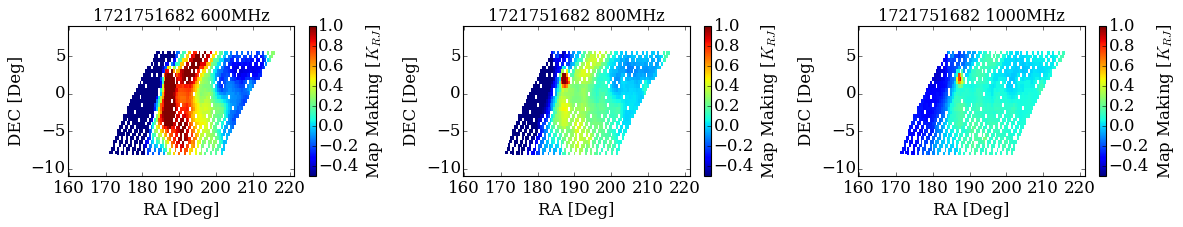

<Figure size 640x480 with 0 Axes>

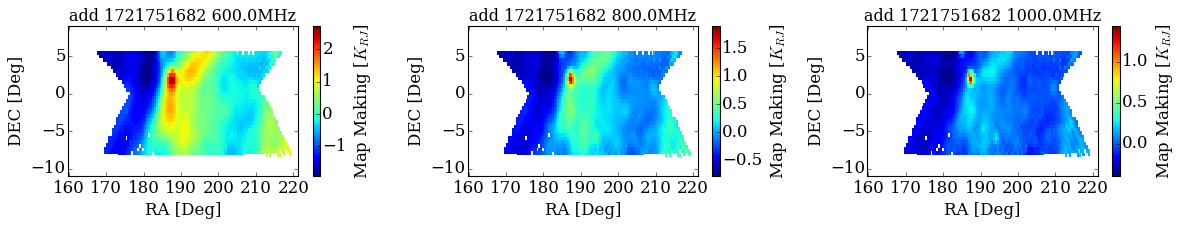

<Figure size 640x480 with 0 Axes>

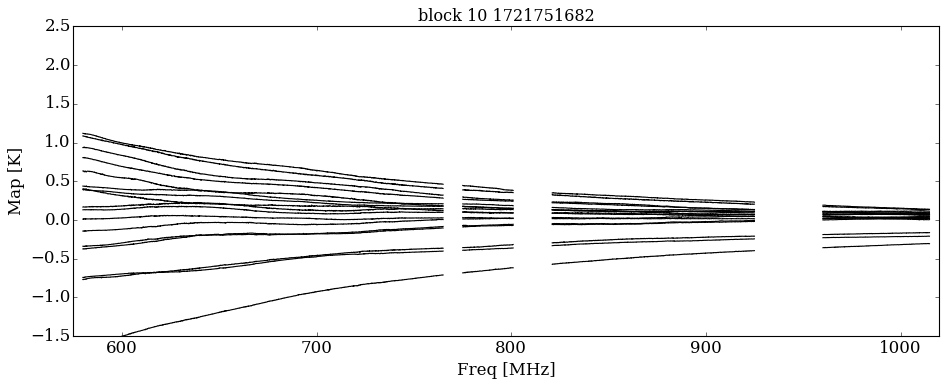

<Figure size 640x480 with 0 Axes>

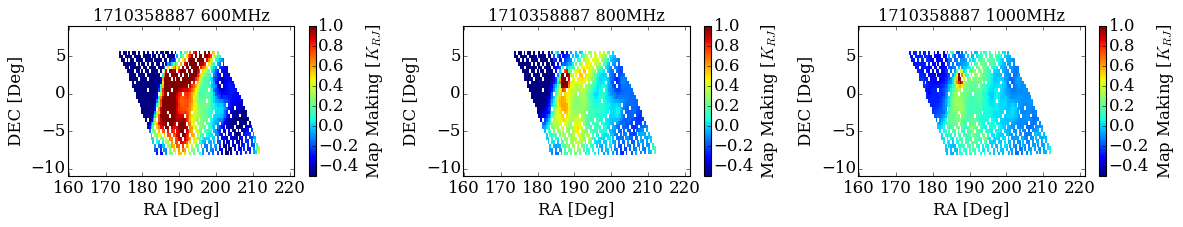

<Figure size 640x480 with 0 Axes>

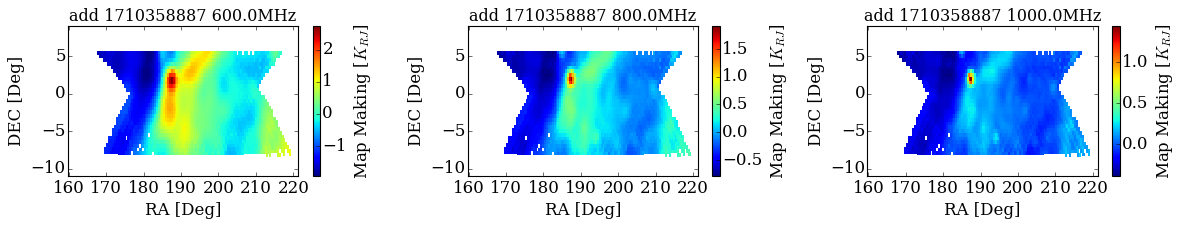

<Figure size 640x480 with 0 Axes>

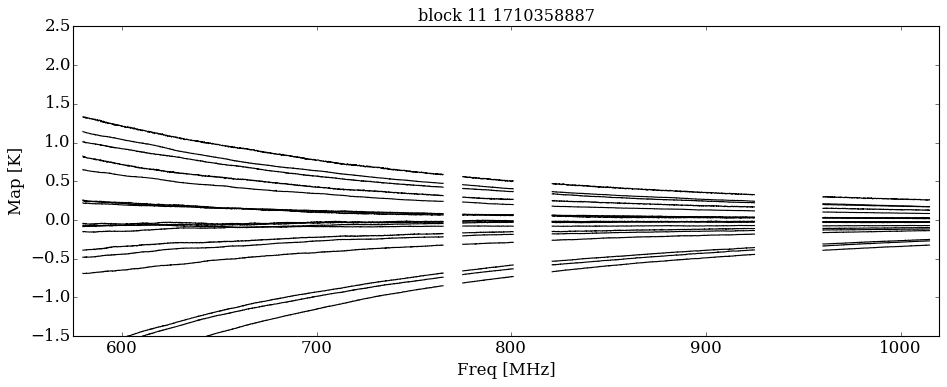

<Figure size 640x480 with 0 Axes>

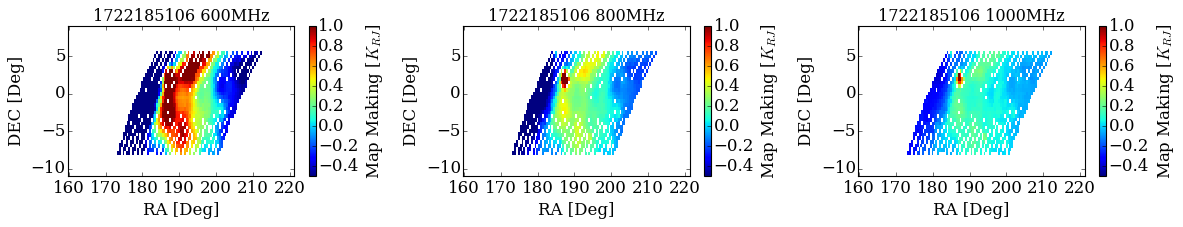

<Figure size 640x480 with 0 Axes>

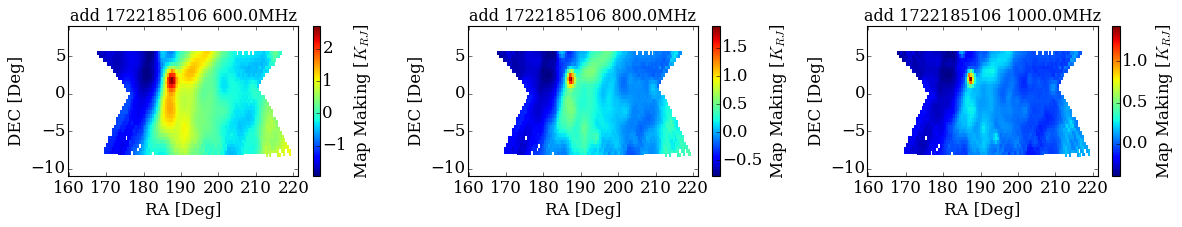

<Figure size 640x480 with 0 Axes>

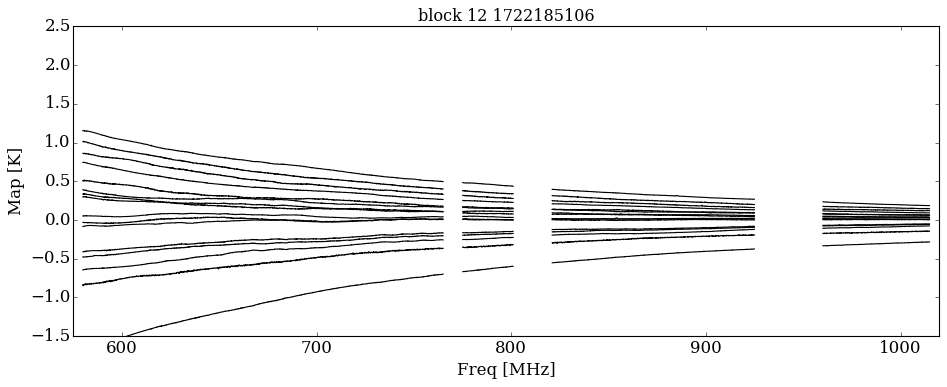

<Figure size 640x480 with 0 Axes>

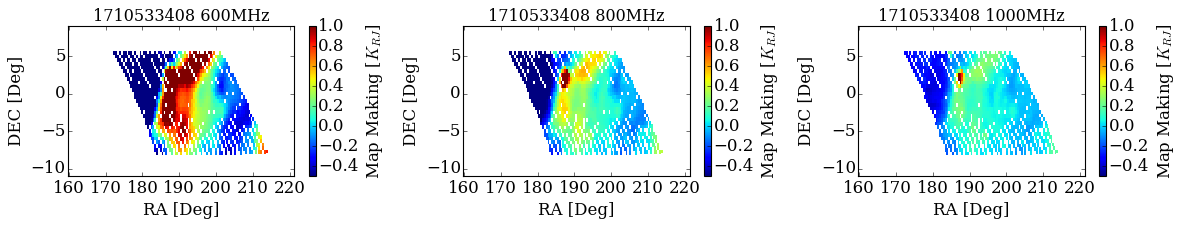

<Figure size 640x480 with 0 Axes>

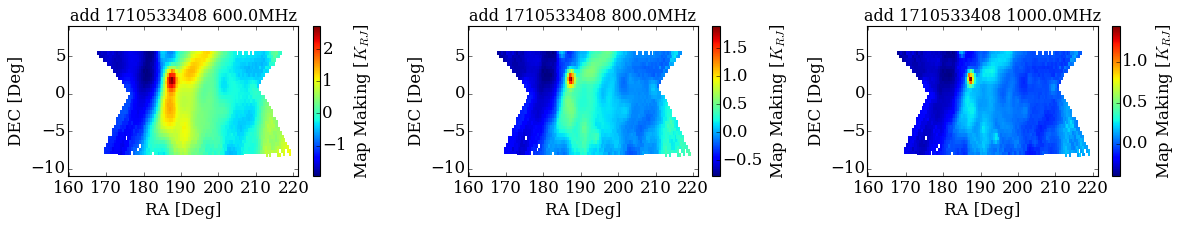

<Figure size 640x480 with 0 Axes>

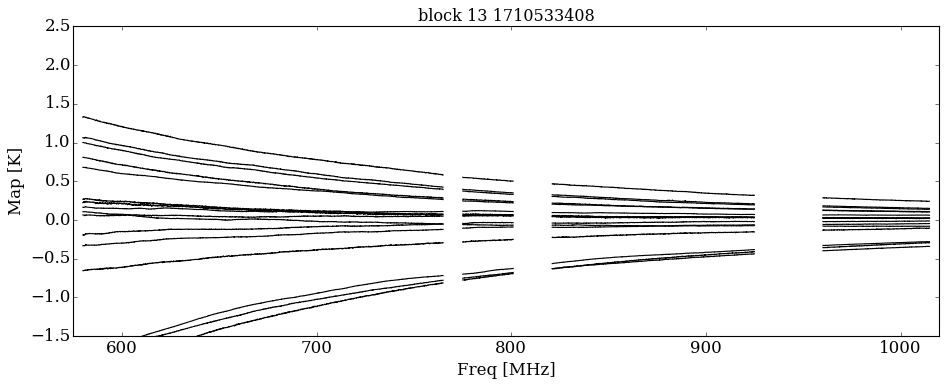

<Figure size 640x480 with 0 Axes>

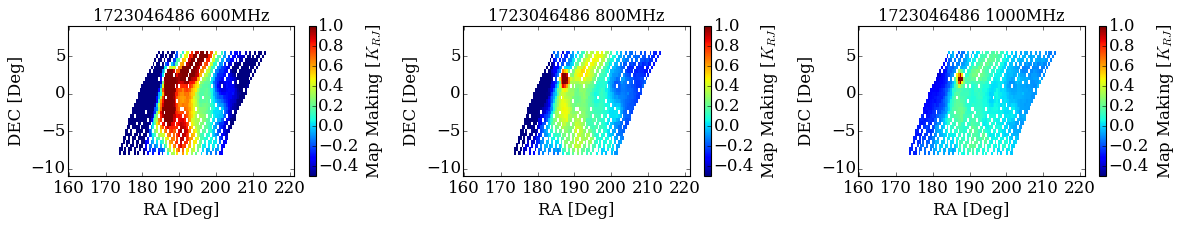

<Figure size 640x480 with 0 Axes>

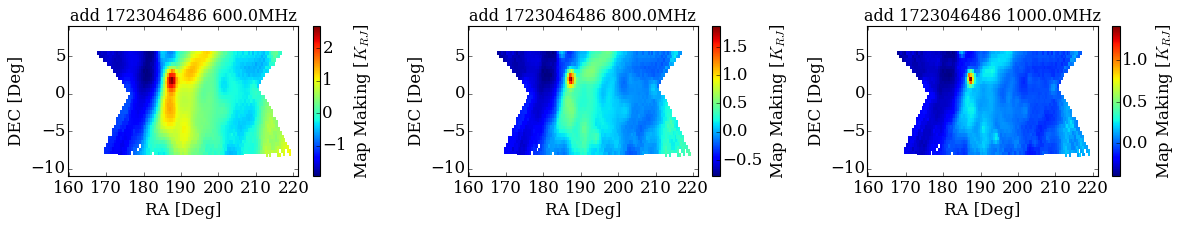

<Figure size 640x480 with 0 Axes>

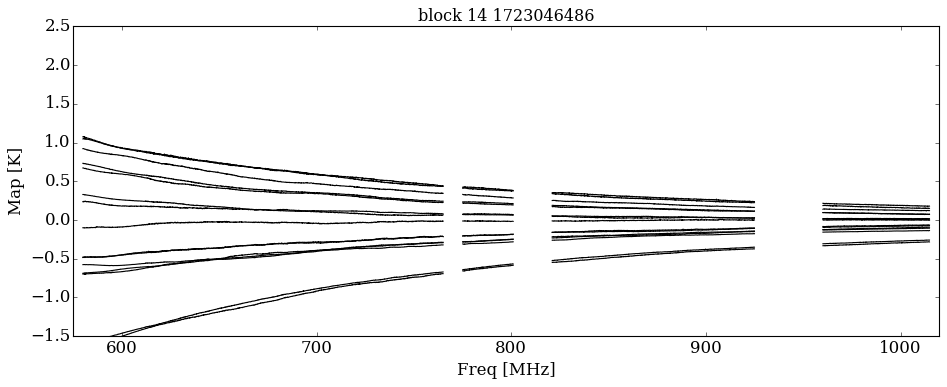

<Figure size 640x480 with 0 Axes>

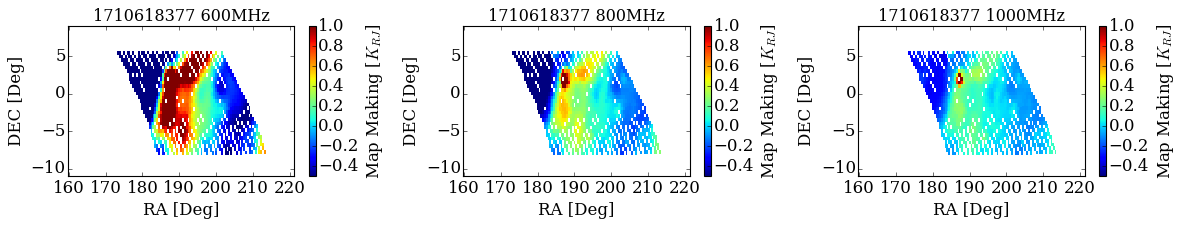

<Figure size 640x480 with 0 Axes>

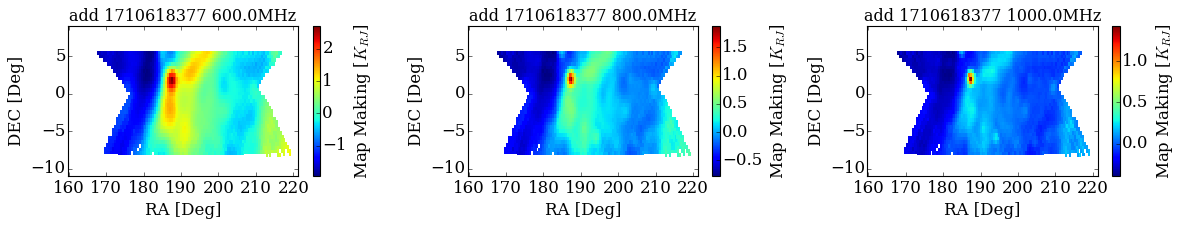

<Figure size 640x480 with 0 Axes>

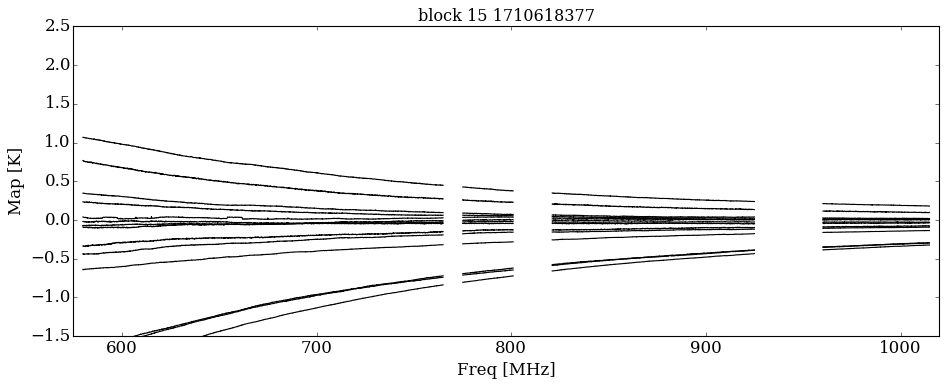

<Figure size 640x480 with 0 Axes>

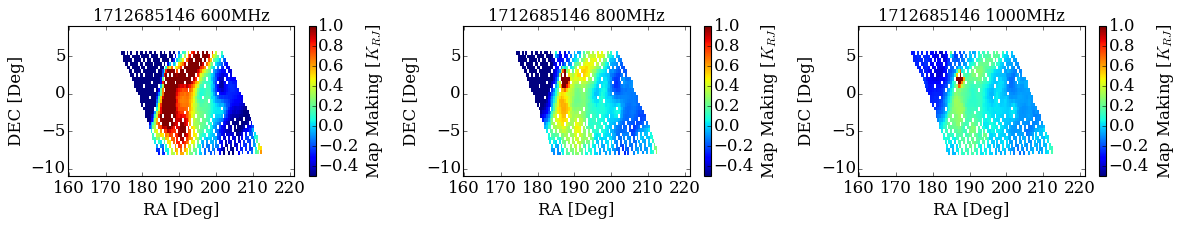

<Figure size 640x480 with 0 Axes>

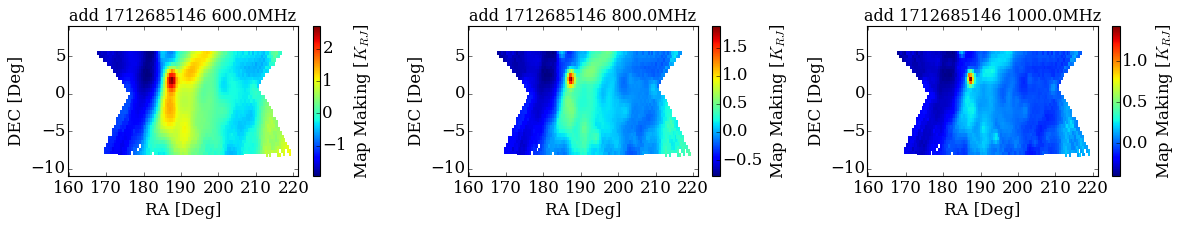

<Figure size 640x480 with 0 Axes>

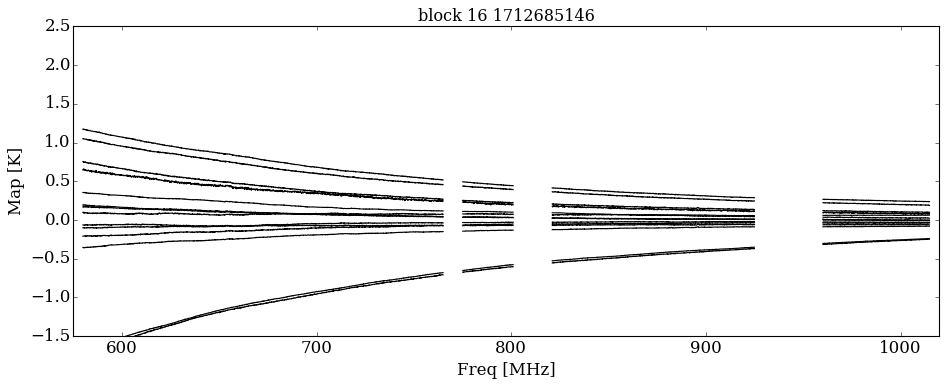

<Figure size 640x480 with 0 Axes>

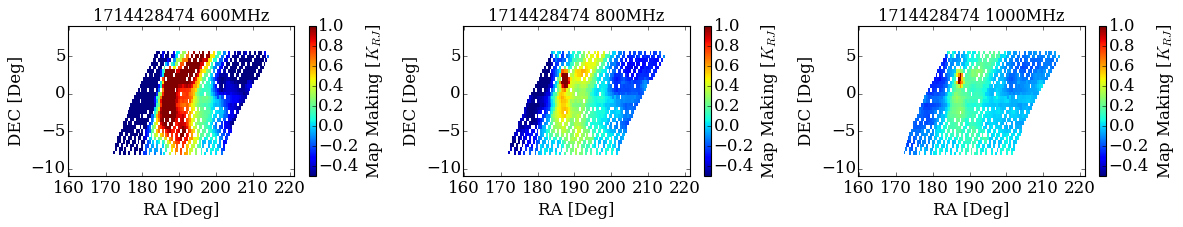

<Figure size 640x480 with 0 Axes>

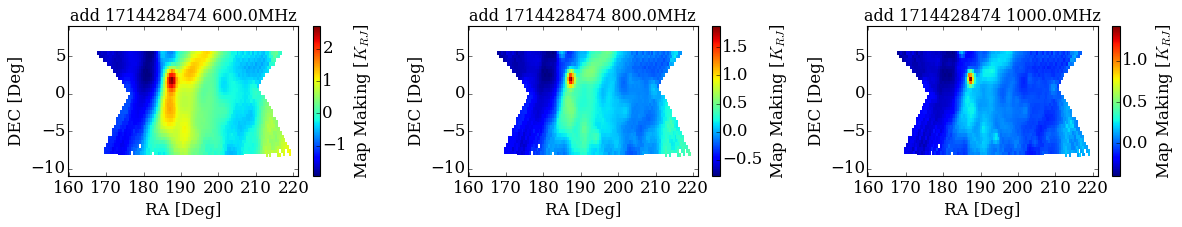

<Figure size 640x480 with 0 Axes>

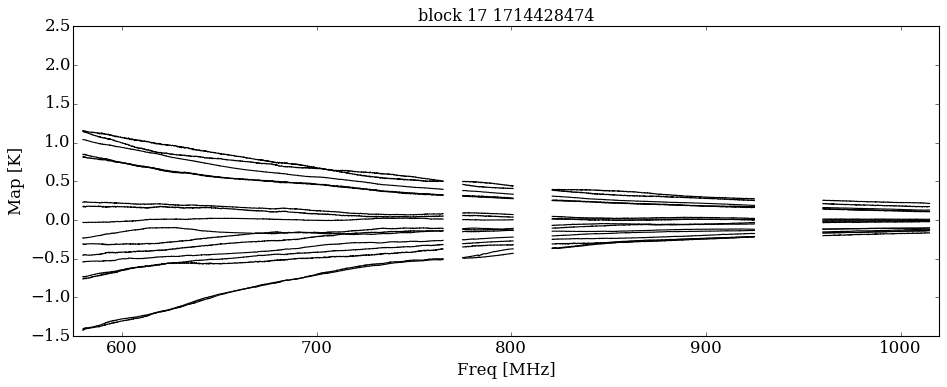

<Figure size 640x480 with 0 Axes>

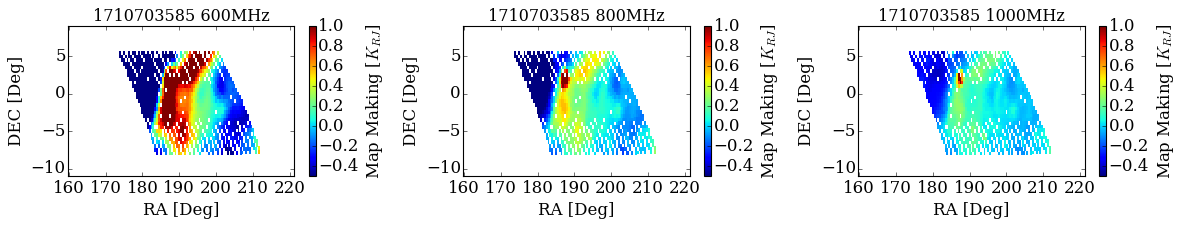

<Figure size 640x480 with 0 Axes>

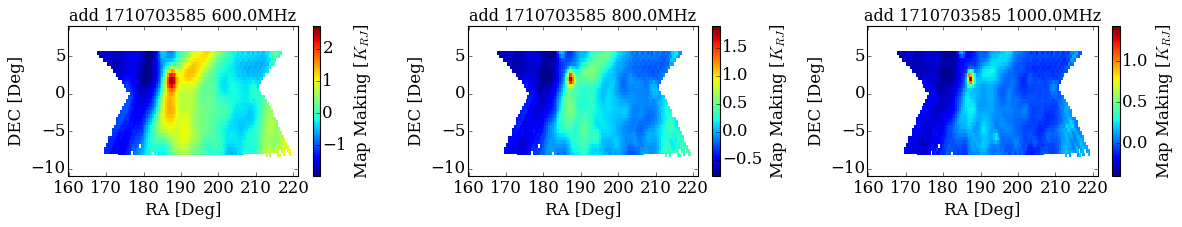

<Figure size 640x480 with 0 Axes>

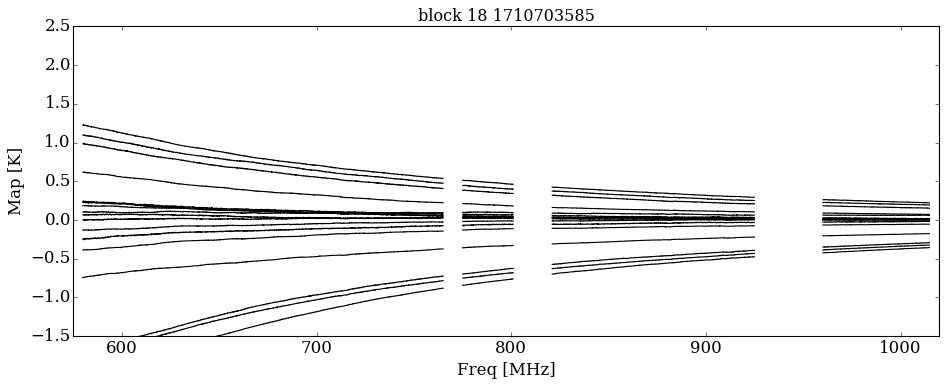

<Figure size 640x480 with 0 Axes>

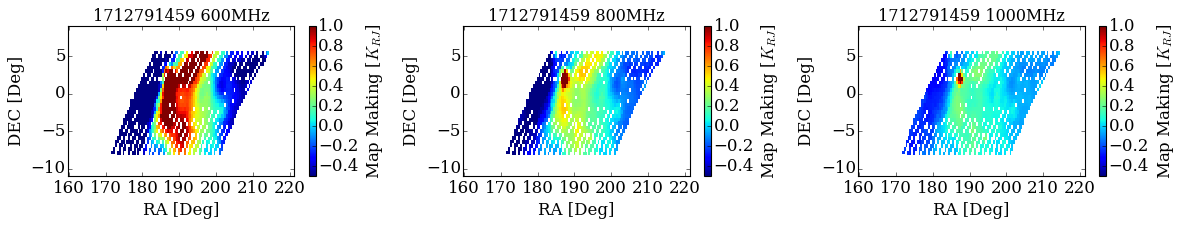

<Figure size 640x480 with 0 Axes>

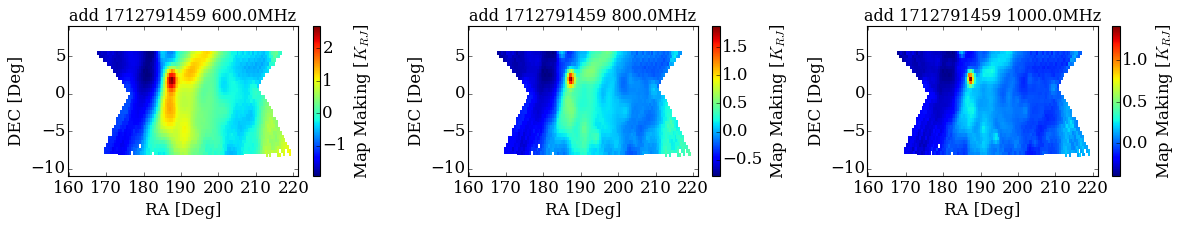

<Figure size 640x480 with 0 Axes>

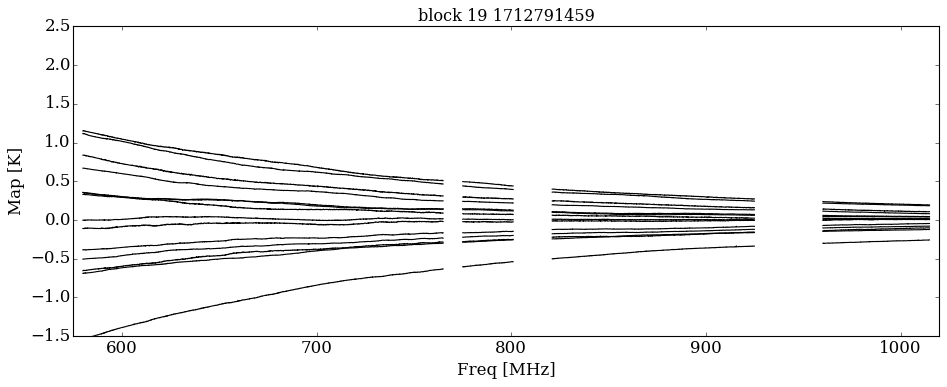

<Figure size 640x480 with 0 Axes>

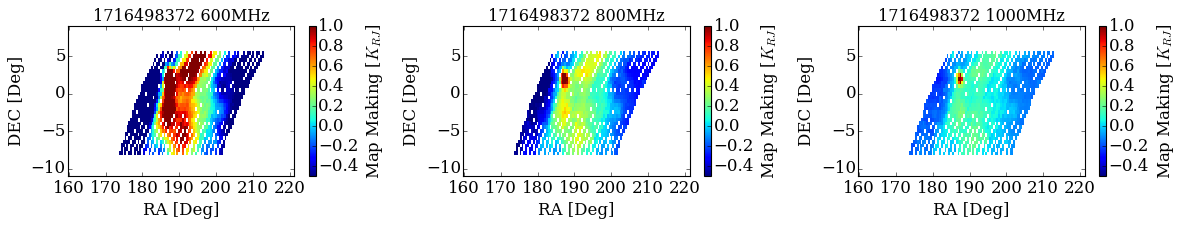

<Figure size 640x480 with 0 Axes>

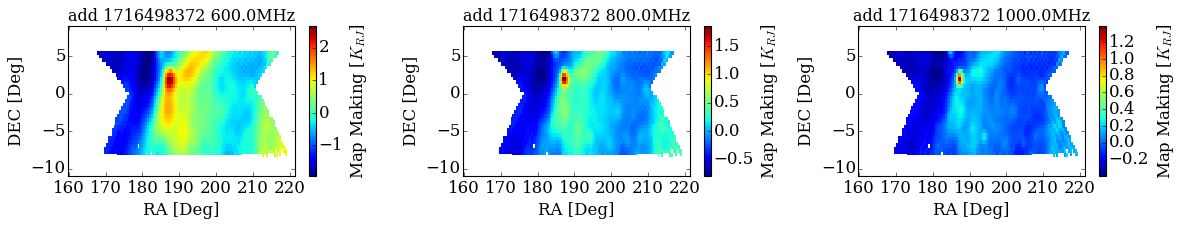

<Figure size 640x480 with 0 Axes>

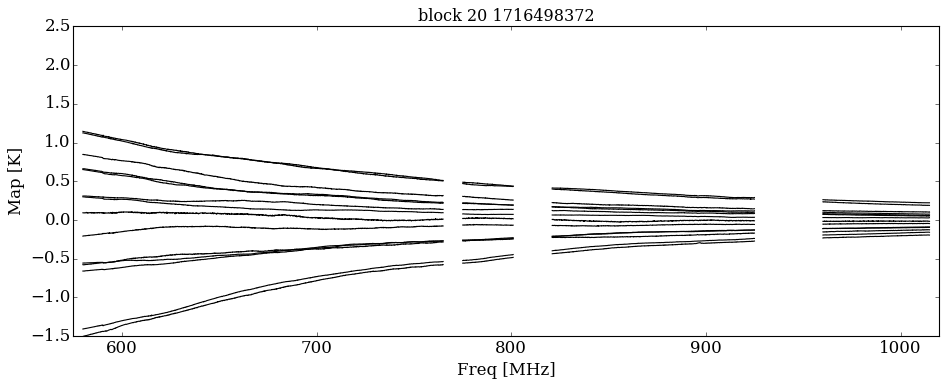

<Figure size 640x480 with 0 Axes>

In [3]:
# loading the data of each block and save to a list 

allmap_list = []
hit_data_list = []
hit_data_nomask_list = []
for block_name in block_process_list:
    
    data_read=pickle.load(open(input_path+'/map_making_'+BOX+'_'+block_name+map_version+'.pkl','rb'))
    hit_data = data_read['hit']
    hit_data_nomask = data_read['hit_nomask']
    freq = data_read['freq']
    antenna_list = data_read['antenna_list']
    map_making_data_block = data_read['map']
    wcs = data_read['wcs']
    
    # set the shape of map 
    map_shape = map_making_data_block.shape
    # Assume image_shape = [ra_length, dec_length]
    ra_len, dec_len = map_shape[0], map_shape[1]
    # Create a pixel grid (Y for Dec, X for RA)
    y, x = np.mgrid[0:dec_len, 0:ra_len]
    # Convert pixel coordinates to world coordinates
    ra, dec = wcs.wcs_pix2world(x, y, 0)
    
    allmap_list.append(map_making_data_block)
    hit_data_list.append(hit_data)
    hit_data_nomask_list.append(hit_data_nomask)

    ########  calculate map_mapcombine_sub   
    allmap_array = np.ma.masked_array(allmap_list)
    # Calculate the expression T[n] + T[n+1] - T[n-1] - T[n+2] for valid indices
    delta = (allmap_array[:,:,:,1:-2] + allmap_array[:,:,:,2:-1] - allmap_array[:,:,:,:-3] - allmap_array[:,:,:,3:]) / 2.
    weight = 1. / np.ma.std(delta, axis=-1)
    weight_ex = np.repeat(weight[:,:,:,np.newaxis], allmap_array.shape[-1], axis=3)
    map_mapcombine_sub = np.ma.average(allmap_array, axis=0, weights=weight_ex)
    
        
    fig = plt.figure(figsize=(15, 3))
    ax = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)
        
    freq_plot = 600
    index_freq_plot = np.argmin(np.abs(freq-freq_plot))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        map_plot = np.ma.median(map_making_data_block[:,:,index_freq_plot-30:index_freq_plot+30], axis=-1)
    mk_data = ax.pcolormesh(ra, dec, map_plot.T, vmin=-0.5, vmax=1.)
    ax.set_xlabel('RA [Deg]', fontsize=15)
    ax.set_ylabel('DEC [Deg]', fontsize=15)
    ax.set_title(block_name+ ' ' +str(freq_plot) + 'MHz')
    ax.set_xlim(ra.min(), ra.max())
    ax.set_ylim(dec.min(), dec.max())
    cbar_mp = plt.colorbar(mk_data)
    cbar_mp.set_label(r'Map Making [$K_{RJ}$]', fontsize=15)

    freq_plot = 800
    index_freq_plot = np.argmin(np.abs(freq-freq_plot))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        map_plot = np.ma.median(map_making_data_block[:,:,index_freq_plot-30:index_freq_plot+30], axis=-1)
    mk_data = ax2.pcolormesh(ra, dec, map_plot.T, vmin=-0.5, vmax=1.)
    ax2.set_xlabel('RA [Deg]', fontsize=15)
    ax2.set_ylabel('DEC [Deg]', fontsize=15)
    ax2.set_title(block_name+ ' ' +str(freq_plot) + 'MHz')
    ax2.set_xlim(ra.min(), ra.max())
    ax2.set_ylim(dec.min(), dec.max())
    cbar_mp = plt.colorbar(mk_data)
    cbar_mp.set_label(r'Map Making [$K_{RJ}$]', fontsize=15)

    freq_plot = 1000
    index_freq_plot = np.argmin(np.abs(freq-freq_plot))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        map_plot = np.ma.median(map_making_data_block[:,:,index_freq_plot-30:index_freq_plot+30], axis=-1)
    mk_data = ax3.pcolormesh(ra, dec, map_plot.T, vmin=-0.5, vmax=1.)
    #ax3.scatter(ra[i], dec[j], marker='o', facecolor='none', s=20)
    ax3.set_xlabel('RA [Deg]', fontsize=15)
    ax3.set_ylabel('DEC [Deg]', fontsize=15)
    ax3.set_title(block_name+ ' ' +str(freq_plot) + 'MHz')
    ax3.set_xlim(ra.min(), ra.max())
    ax3.set_ylim(dec.min(), dec.max())
    cbar_mp = plt.colorbar(mk_data)
    cbar_mp.set_label(r'Map Making [$K_{RJ}$]', fontsize=15)
    
    plt.tight_layout()
    plt.show()
    plt.clf()
                
        


    fig = plt.figure(figsize=(15, 3))
    ax = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)
        
    freq_plot = 600.
    index_freq_plot = np.argmin(np.abs(freq-freq_plot))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        map_plot = np.ma.median(map_mapcombine_sub[:,:,index_freq_plot-30:index_freq_plot+30], axis=-1)
    mk_data = ax.pcolormesh(ra, dec, map_plot.T)
    ax.set_xlabel('RA [Deg]', fontsize=15)
    ax.set_ylabel('DEC [Deg]', fontsize=15)
    ax.set_title('add '+block_name+ ' ' +str(freq_plot) + 'MHz')
    ax.set_xlim(ra.min(), ra.max())
    ax.set_ylim(dec.min(), dec.max())
    cbar_mp = plt.colorbar(mk_data)
    cbar_mp.set_label(r'Map Making [$K_{RJ}$]', fontsize=15)

    freq_plot = 800.
    index_freq_plot = np.argmin(np.abs(freq-freq_plot))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        map_plot = np.ma.median(map_mapcombine_sub[:,:,index_freq_plot-30:index_freq_plot+30], axis=-1)
    mk_data = ax2.pcolormesh(ra, dec, map_plot.T)
    ax2.set_xlabel('RA [Deg]', fontsize=15)
    ax2.set_ylabel('DEC [Deg]', fontsize=15)
    ax2.set_title('add '+block_name+ ' ' +str(freq_plot) + 'MHz')
    ax2.set_xlim(ra.min(), ra.max())
    ax2.set_ylim(dec.min(), dec.max())
    cbar_mp = plt.colorbar(mk_data)
    cbar_mp.set_label(r'Map Making [$K_{RJ}$]', fontsize=15)

    freq_plot = 1000.
    index_freq_plot = np.argmin(np.abs(freq-freq_plot))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        map_plot = np.ma.median(map_mapcombine_sub[:,:,index_freq_plot-30:index_freq_plot+30], axis=-1)
    mk_data = ax3.pcolormesh(ra, dec, map_plot.T)
    ax3.set_xlabel('RA [Deg]', fontsize=15)
    ax3.set_ylabel('DEC [Deg]', fontsize=15)
    ax3.set_title('add '+block_name+ ' ' +str(freq_plot) + 'MHz')
    ax3.set_xlim(ra.min(), ra.max())
    ax3.set_ylim(dec.min(), dec.max())
    cbar_mp = plt.colorbar(mk_data)
    cbar_mp.set_label(r'Map Making [$K_{RJ}$]', fontsize=15)
    
    plt.tight_layout()
    plt.show()
    plt.clf()

    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    for i in range(map_making_data_block.shape[0])[::10]:
        for j in range(map_making_data_block.shape[1])[::10]:
           ax.plot(freq, map_making_data_block[i,j], color='black', lw=1)
    
    ax.set_xlabel('Freq [MHz]', fontsize=15)    
    ax.set_ylabel('Map [K]', fontsize=15)
    ax.set_xlim(freq.min()-5, freq.max()+5)
    ax.set_ylim(-1.5,2.5)
    ax.set_title('block '+str(block_process_list.index(block_name)+1)+' '+block_name)
    plt.tight_layout()
    plt.show()
    plt.clf()
    


In [4]:
# combining maps from all blocks

allmap_array = np.ma.masked_array(allmap_list)
hit_data_array = np.array(hit_data_list)
hit_data_nomask_array = np.array(hit_data_nomask_list)

# Calculate the ABBA T[n] + T[n+1] - T[n-1] - T[n+2] for weight estimation
delta = (allmap_array[:,:,:,1:-2] + allmap_array[:,:,:,2:-1] - allmap_array[:,:,:,:-3] - allmap_array[:,:,:,3:]) / 2.
weight = 1. / np.ma.std(delta, axis=-1)
#weight = weight.filled(0)
weight_ex = np.repeat(weight[:,:,:,np.newaxis], allmap_array.shape[-1], axis=3)

map_mapcombine = np.ma.average(allmap_array, axis=0, weights=weight_ex)
hit_data_mapcombine = np.sum(hit_data_array, axis=0)
hit_data_nomask_mapcombine = np.sum(hit_data_nomask_array, axis=0)

/users/wkhu/environment/museek/lib/python3.10/site-packages/matplotlib/cbook.py:1719: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


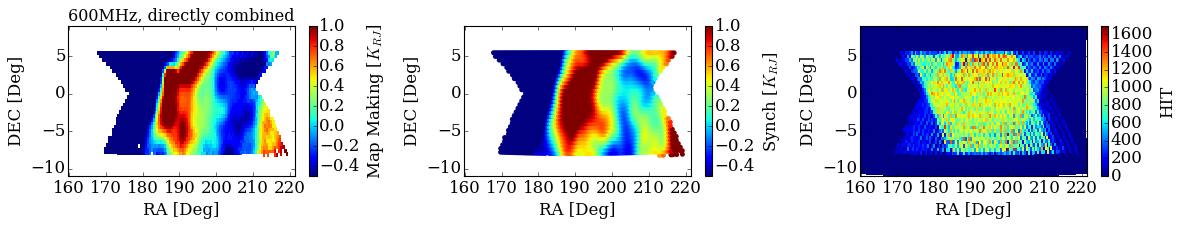

<Figure size 640x480 with 0 Axes>

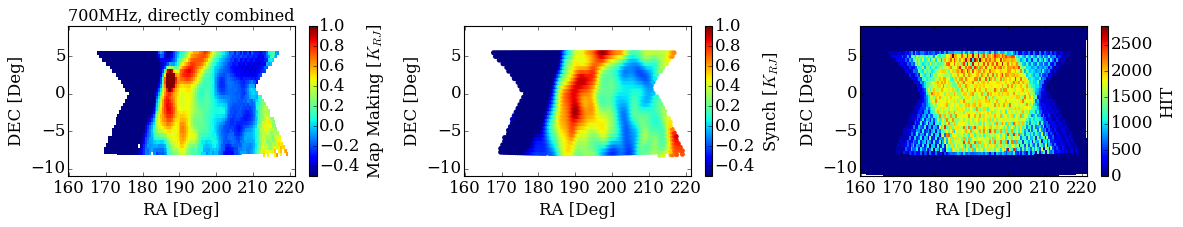

<Figure size 640x480 with 0 Axes>

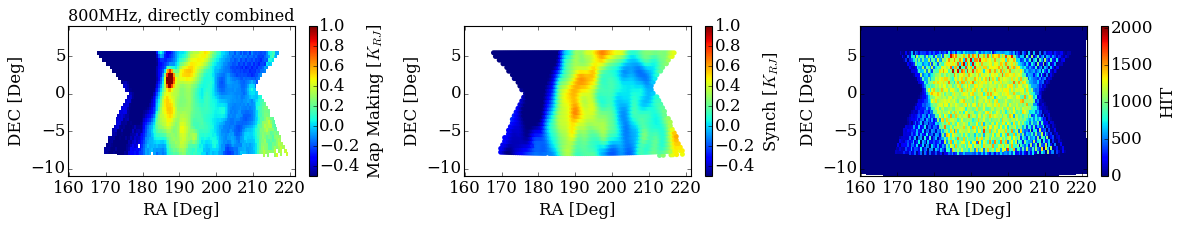

<Figure size 640x480 with 0 Axes>

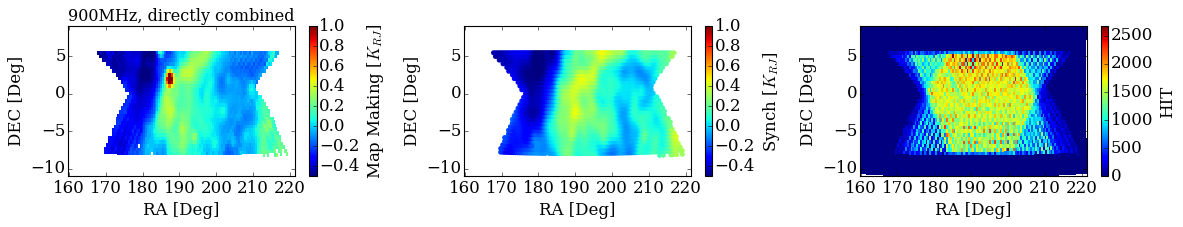

<Figure size 640x480 with 0 Axes>

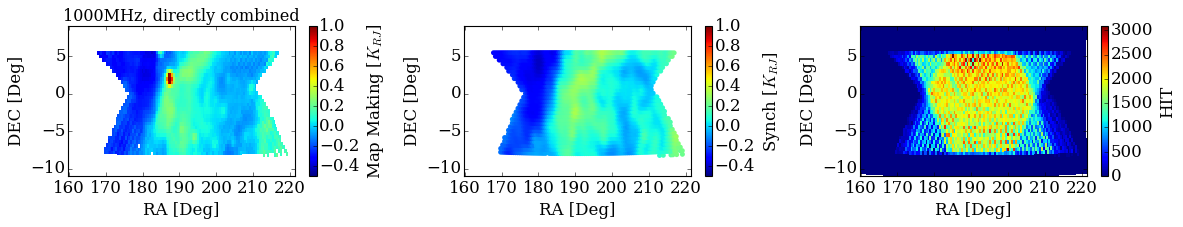

<Figure size 640x480 with 0 Axes>

In [5]:
#######   map-making for synch and compared with scan data, all antennas combined  #############

nside=128             # resolution parameter at which the synchrotron model is to be calculated
beamsize=57.5         # the beam fwhm used to smooth the Synch model [arcmin]
beam_frequency=1500.  # reference frequency at which the beam fwhm are defined [MHz]
sky = pysm3.Sky(nside=nside, preset_strings=["s1"])  # Here we use "s1" vresion of synch model, please see https://pysm3.readthedocs.io/en/latest/models.html#synchrotron

freq_plot_list = np.arange(600, 1020, 100)

for freq_plot in freq_plot_list:
    index_freq_plot = np.argmin(np.abs(freq-freq_plot))

    if map_mapcombine[:,:,index_freq_plot].mask.all():
        print (str(freq_plot) + 'MHz is masked')
    else:
        #########   produce synch model at a certain frequency and smooth   #########
        map_reference = sky.get_emission(freq_plot * u.MHz).value
        map_reference_smoothed = pysm3.apply_smoothing_and_coord_transform(map_reference, fwhm=beamsize*u.arcmin * ((beam_frequency*u.MHz)/(freq_plot * u.MHz)).decompose().value )

        #########   map the smoothed synch model to the same sky covered by ra,dec of scan_data
        c = SkyCoord(ra=ra.flatten() * u.degree, dec=dec.flatten() * u.degree, frame='icrs')
        theta = 90. - (c.galactic.b / u.degree).value
        phi = (c.galactic.l / u.degree).value
        synch_I = hp.pixelfunc.get_interp_val(map_reference_smoothed[0], theta / 180. * np.pi, phi / 180. * np.pi)
        synch_I = synch_I / 10**6.  
        synch_I = np.ma.masked_array(synch_I, mask=map_mapcombine[:,:,index_freq_plot].T.mask)
        synch_I = synch_I - np.ma.mean(synch_I)

        

        map_making_data_plot = map_mapcombine[:,:,index_freq_plot]
        fig = plt.figure(figsize=(15, 3))
        ax = fig.add_subplot(1, 3, 1)
        mk_data = plt.pcolormesh(ra, dec, map_making_data_plot.T, vmax=1.0, vmin=-0.5)
        ax.set_xlabel('RA [Deg]', fontsize=15)
        ax.set_ylabel('DEC [Deg]', fontsize=15)
        ax.set_title(str(freq_plot) + 'MHz, directly combined')
        ax.set_xlim(ra.min(), ra.max())
        ax.set_ylim(dec.min(), dec.max())
        cbar_mp = plt.colorbar(mk_data)
        cbar_mp.set_label(r'Map Making [$K_{RJ}$]', fontsize=15)
        
        ax2 = fig.add_subplot(1, 3, 2)
        mk_data = plt.scatter(ra.flatten(), dec.flatten(), c=synch_I, edgecolor='None', vmax=1.0, vmin=-0.5)
        ax2.set_xlabel('RA [Deg]', fontsize=15)
        ax2.set_ylabel('DEC [Deg]', fontsize=15)
        ax2.set_xlim(ra.min(), ra.max())
        ax2.set_ylim(dec.min(), dec.max())
        cbar_mp = plt.colorbar(mk_data)
        cbar_mp.set_label(r'Synch [$K_{RJ}$]', fontsize=15)

        ax3 = fig.add_subplot(1, 3, 3)
        mk_data = plt.pcolormesh(ra, dec, np.median(hit_data_mapcombine[:,:,index_freq_plot-30:index_freq_plot+30], axis=-1).T)
        ax3.set_xlabel('RA [Deg]', fontsize=15)
        ax3.set_ylabel('DEC [Deg]', fontsize=15)
        ax3.set_xlim(ra.min(), ra.max())
        ax3.set_ylim(dec.min(), dec.max())
        cbar_mp = plt.colorbar(mk_data)
        cbar_mp.set_label('HIT', fontsize=15)
        
        plt.tight_layout()
        plt.show()
        plt.clf()

            

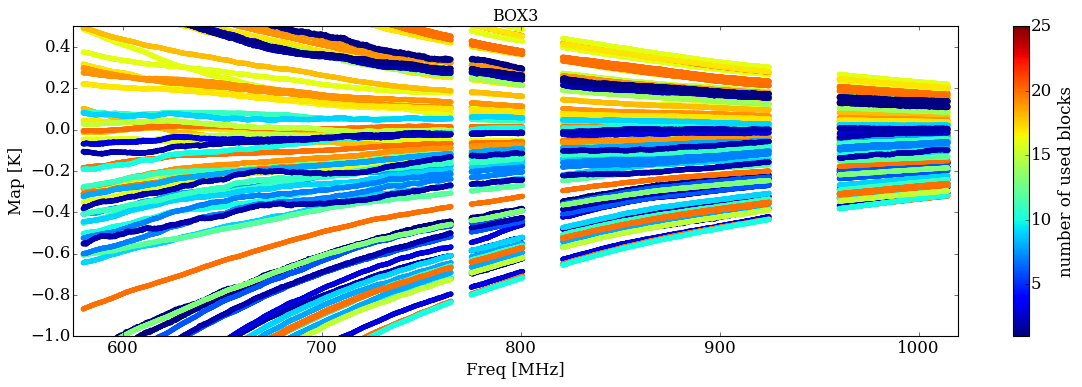

<Figure size 640x480 with 0 Axes>

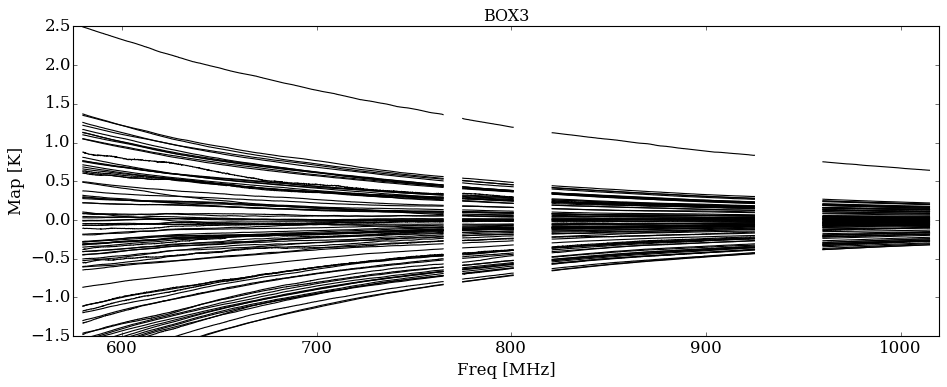

<Figure size 640x480 with 0 Axes>

In [6]:
# checking the spectra for final data cube

mask_mapcombine_sum = np.sum(~allmap_array.mask, axis=0)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
for i in range(map_mapcombine.shape[0])[::5]:
    for j in range(map_mapcombine.shape[1])[::5]:
        sc = ax.scatter(freq, map_mapcombine[i,j], c=mask_mapcombine_sum[i,j], edgecolor='None', vmin=1, vmax=25)

            
ax.set_xlabel('Freq [MHz]', fontsize=15)    
ax.set_ylabel('Map [K]', fontsize=15)
ax.set_xlim(freq.min()-5, freq.max()+5)
cbar_mp = fig.colorbar(sc)
cbar_mp.set_label('number of used blocks', fontsize=15)
ax.set_ylim(-1,0.5)
ax.set_title(BOX)
plt.tight_layout()
plt.show()
plt.clf()

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)
for i in range(map_mapcombine.shape[0])[::5]:
    for j in range(map_mapcombine.shape[1])[::5]:
        ax.plot(freq, map_mapcombine[i,j], color='black', lw=1)


ax.set_xlabel('Freq [MHz]', fontsize=15)    
ax.set_ylabel('Map [K]', fontsize=15)
ax.set_xlim(freq.min()-5, freq.max()+5)
ax.set_ylim(-1.5,2.5)
ax.set_title(BOX)
plt.tight_layout()
plt.show()
plt.clf()

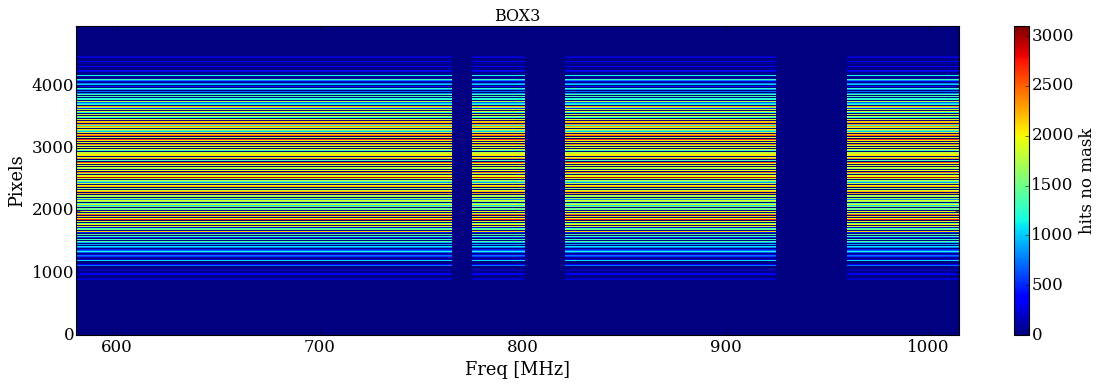

<Figure size 640x480 with 0 Axes>

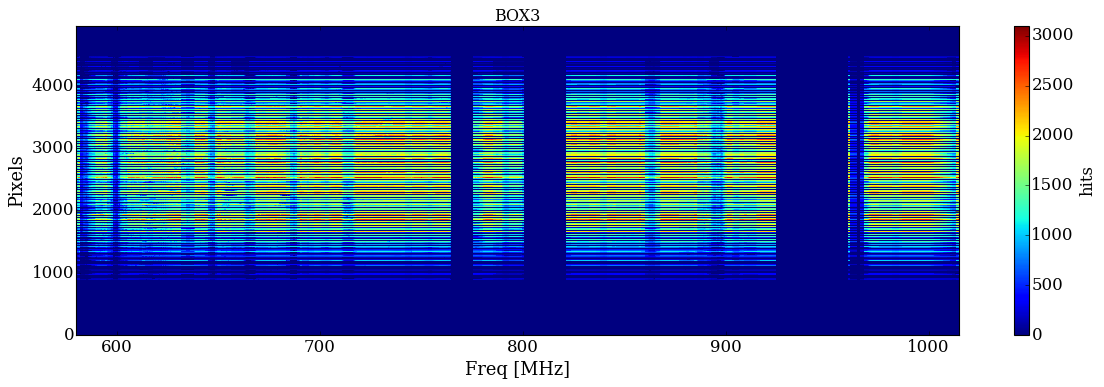

<Figure size 640x480 with 0 Axes>

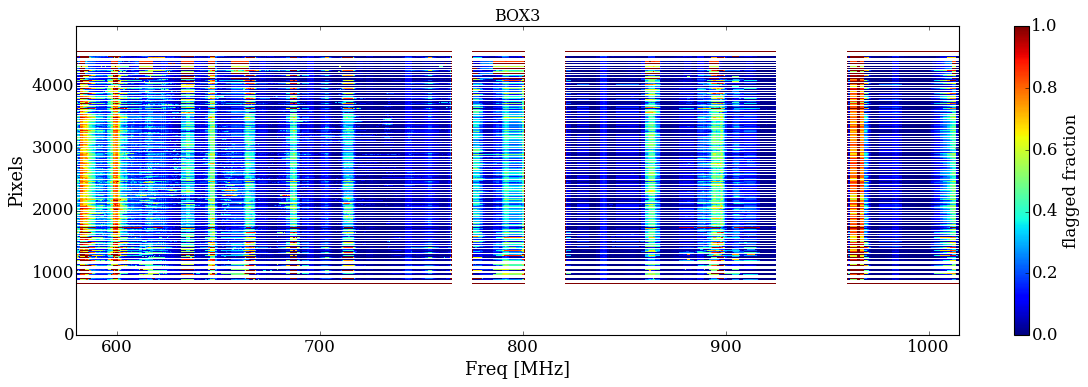

<Figure size 640x480 with 0 Axes>

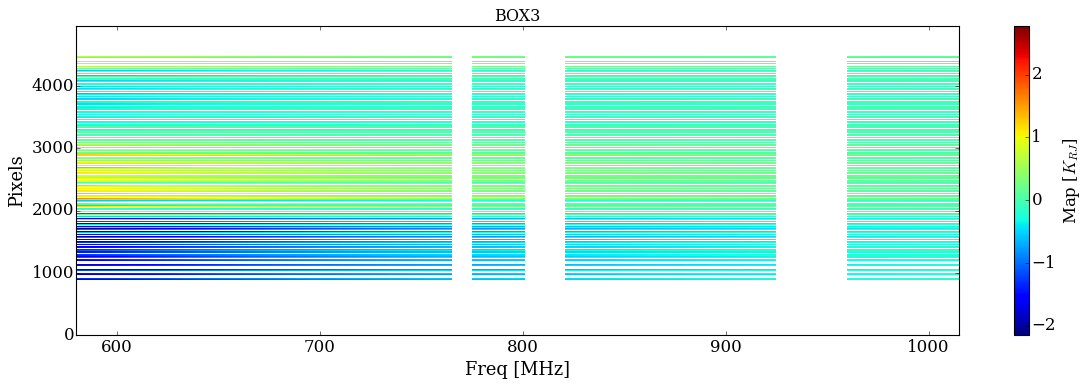

<Figure size 640x480 with 0 Axes>

In [7]:
# check the waterfall plots after the second inpainting 

shape_0 = np.shape(map_mapcombine)[0]
shape_1 = np.shape(map_mapcombine)[1]
shape_2 = np.shape(map_mapcombine)[2]

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
map1 = ax.pcolormesh(freq, np.arange(shape_0*shape_1), hit_data_nomask_mapcombine.reshape(shape_0*shape_1, shape_2))
ax.set_xlabel('Freq [MHz]', fontsize=16)
ax.set_ylabel('Pixels', fontsize=16)
ax.set_xlim(freq.min(), freq.max())
ax.set_ylim(0, shape_0*shape_1)
ax.set_title(BOX)
cbar_data = plt.colorbar(map1)
cbar_data.set_label('hits no mask', fontsize=15)
plt.tight_layout()
plt.show()
plt.clf()

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
map1 = ax.pcolormesh(freq, np.arange(shape_0*shape_1), hit_data_mapcombine.reshape(shape_0*shape_1, shape_2))
ax.set_xlabel('Freq [MHz]', fontsize=16)
ax.set_ylabel('Pixels', fontsize=16)
ax.set_xlim(freq.min(), freq.max())
ax.set_ylim(0, shape_0*shape_1)
ax.set_title(BOX)
cbar_data = plt.colorbar(map1)
cbar_data.set_label('hits', fontsize=15)
plt.tight_layout()
plt.show()
plt.clf()

hit_data_nomask_mapcombine_ma = np.ma.masked_array(hit_data_nomask_mapcombine, mask=hit_data_nomask_mapcombine==0)
hit_data_mapcombine_ma = np.ma.masked_array(hit_data_mapcombine, mask=hit_data_nomask_mapcombine==0)
flagged_fraction_mapcombine = (hit_data_nomask_mapcombine_ma - hit_data_mapcombine_ma) / hit_data_nomask_mapcombine_ma
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
map1 = ax.pcolormesh(freq, np.arange(shape_0*shape_1), flagged_fraction_mapcombine.reshape(shape_0*shape_1, shape_2))
ax.set_xlabel('Freq [MHz]', fontsize=16)
ax.set_ylabel('Pixels', fontsize=16)
ax.set_xlim(freq.min(), freq.max())
ax.set_ylim(0, shape_0*shape_1)
ax.set_title(BOX)
cbar_data = plt.colorbar(map1)
cbar_data.set_label('flagged fraction', fontsize=15)
plt.tight_layout()
plt.show()
plt.clf()

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
map1 = ax.pcolormesh(freq, np.arange(shape_0*shape_1), map_mapcombine.reshape(shape_0*shape_1, shape_2))
ax.set_xlabel('Freq [MHz]', fontsize=16)
ax.set_ylabel('Pixels', fontsize=16)
ax.set_xlim(freq.min(), freq.max())
ax.set_ylim(0, shape_0*shape_1)
ax.set_title(BOX)
cbar_data = plt.colorbar(map1)
cbar_data.set_label(r'Map [$K_{RJ}$]', fontsize=15)
plt.tight_layout()
plt.show()
plt.clf()



In [8]:
# save the map-making results

arrays_dict = {
            'map': map_mapcombine,
            'hit': hit_data_mapcombine,
            'hit_nomask': hit_data_nomask_mapcombine,
            'wcs': wcs, 
            'freq':freq,
            'antenna_list':antenna_list,
            }

if not os.path.exists(output_path):
    os.makedirs(output_path)
    print(f"Directory '{output_path}' was created.")
else:
    print(f"Directory '{output_path}' already exists.")
    
with open(output_path+'/map_making_'+BOX+map_version+'_blockscombined.pkl', 'wb') as f:
    pickle.dump(arrays_dict, f)


'\narrays_dict = {\n            \'map\': map_mapcombine,\n            \'hit\': hit_data_mapcombine,\n            \'hit_nomask\': hit_data_nomask_mapcombine,\n            \'wcs\': wcs, \n            \'freq\':freq,\n            \'antenna_list\':antenna_list,\n            }\n\nif not os.path.exists(output_path):\n    os.makedirs(output_path)\n    print(f"Directory \'{output_path}\' was created.")\nelse:\n    print(f"Directory \'{output_path}\' already exists.")\n    \nwith open(output_path+\'/map_making_\'+BOX+map_version+\'_blockscombined.pkl\', \'wb\') as f:\n    pickle.dump(arrays_dict, f)\n'

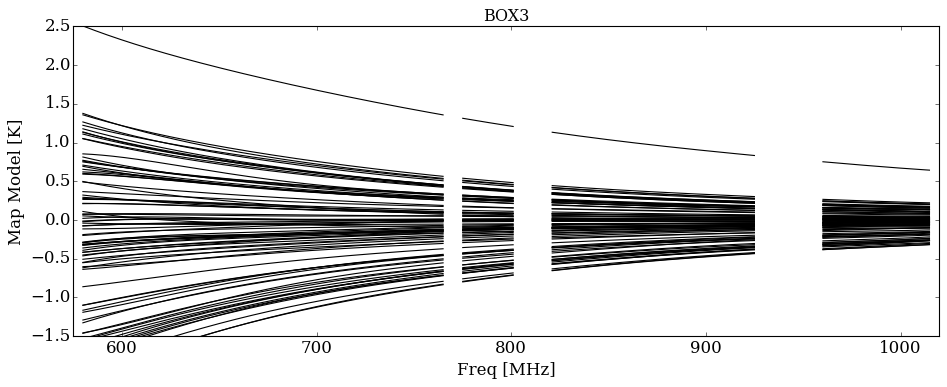

<Figure size 640x480 with 0 Axes>

In [9]:
#############   fitting polynomials to blocks' combined map to create the model

map_model = map_mapcombine.copy()
for pixel_i in range(map_mapcombine.shape[0]):
    for pixel_j in range(map_mapcombine.shape[1]):
        if map_mapcombine[pixel_i,pixel_j].mask.all():
            pass
        else:
            map_mask = map_mapcombine[pixel_i,pixel_j,:].mask.copy()
            p_fit = np.polyfit(freq[~map_mask], map_mapcombine.data[pixel_i,pixel_j,~map_mask], deg=model_polyfit_deg)
            map_model.data[pixel_i,pixel_j,:] = np.polyval(p_fit, freq)


fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)
for i in range(map_model.shape[0])[::5]:
    for j in range(map_model.shape[1])[::5]:
        ax.plot(freq, map_model[i,j], color='black', lw=1)

ax.set_xlabel('Freq [MHz]', fontsize=15)    
ax.set_ylabel('Map Model [K]', fontsize=15)
ax.set_xlim(freq.min()-5, freq.max()+5)
ax.set_ylim(-1.5,2.5)
ax.set_title(BOX)
plt.tight_layout()
plt.show()
plt.clf()

In [10]:

# save the model results
if map_version == '_selfcali_inpainting':
    pass
else:
    arrays_dict = {
                'map': map_model,
                'wcs': wcs, 
                'freq':freq,
                'antenna_list':antenna_list,
                }
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)
        print(f"Directory '{output_path}' was created.")
    else:
        print(f"Directory '{output_path}' already exists.")
        
    with open(output_path+'/map_making_'+BOX+'_model.pkl', 'wb') as f:
        pickle.dump(arrays_dict, f)
        


'\n# save the model results\nif map_version == \'_selfcali_inpainting\':\n    pass\nelse:\n    arrays_dict = {\n                \'map\': map_model,\n                \'wcs\': wcs, \n                \'freq\':freq,\n                \'antenna_list\':antenna_list,\n                }\n    \n    if not os.path.exists(output_path):\n        os.makedirs(output_path)\n        print(f"Directory \'{output_path}\' was created.")\n    else:\n        print(f"Directory \'{output_path}\' already exists.")\n        \n    with open(output_path+\'/map_making_\'+BOX+\'_model.pkl\', \'wb\') as f:\n        pickle.dump(arrays_dict, f)\n        \n'